In [102]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.stats.proportion as smp
import en_core_web_sm
from wordsegment import load, segment
import spacy
import nltk
import matplotlib.pyplot as plt
import networkx as nx


# create a database connection to the SQLite database specified by db_file
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn

In [3]:
# create the connection
conn = create_connection("./R_UMD.db")

# make dataframes from each table in the SQLite database
df_user = pd.read_sql("SELECT * FROM User", conn)
df_user_sub = pd.read_sql("SELECT * FROM UserSubreddits", conn)
df_post = pd.read_sql("SELECT * FROM Post", conn)
df_comment = pd.read_sql("SELECT * FROM Comment", conn)

# close connection -- no longer needed
conn.close()

In [4]:
# try and find all bots (usernames end with 'bot')
df_bot = df_user_sub[df_user_sub['name'].str.endswith("bot")]
gb = df_bot.groupby('name')    
gb = [gb.get_group(x) for x in gb.groups]

# remove any row from df_user_sub if it's from a bot
for name in gb :
    df_user_sub = df_user_sub[df_user_sub.name != str(name['name'].reset_index(drop=True)[0])]

### Are users exclusive to r/UMD?
Reddit has become an increasingly popular form of spreading news around campus or promoting a club or event. Because of this, we wanted to investigate how many users are active Redditors and which ones have accounts just to post on r/UMD. As it turns out, about 50% (\~9000) of the users who have ever made a post on r/UMD post on r/UMD infrequently (<25% of their posts). On the other hand, about 25% (~4000) of r/UMD users post exclusively on r/UMD (95% or higher).

In [186]:
# group the dataframe by user
gb = df_user_sub.groupby('name')    
gb = [gb.get_group(x) for x in gb.groups]

l = list()
names = list()

# for each users group of submissions, find out what percentage of them are in r/UMD
for name in gb :
    try :
        l.append([str(name['name'].reset_index(drop=True)[0]), (name[name.subreddit == 'UMD']['subreddit'].value_counts()/name['subreddit'].count())[0]])
    except :
        # User never posted in r/UMD, only commented
        pass

fig = px.histogram(x=[row[1]*100 for row in l], nbins=5, title="Distribution of Users' Percentage of Posts on r/UMD", labels=dict(x="Percentage of Posts in r/UMD"))
fig.update_xaxes(range=[0, 100])
fig.update_layout(yaxis_title="Number of Users")
fig.show()

### So where are they posting if not on r/UMD?
It is clear that despite a large portion of users only posting on r/UMD, there is still a large percentage of users that is active in other subreddits. Below are the top 30 alternative subreddits that r/UMD users post in.

In [219]:
df_non_umd = df_user_sub[df_user_sub.subreddit != 'UMD']
top_subs = (df_non_umd['subreddit'].value_counts()/df_non_umd['subreddit'].count())[:30]*100
subs = top_subs.index.tolist()
vals = top_subs.tolist()

fig = go.Figure()

defaults = ['AskReddit','funny','pics','todayilearned','gaming','videos','IAmA','worldnews','news','aww','gifs','movies',
'mildlyinteresting','Showerthoughts','Music','science','explainlikeimfive','LifeProTips','personalfinance']

c_def = 0
c_oth = 0

for i, sub in enumerate(subs) :
    fig.add_trace(go.Bar(
        x=[sub],
        y=[vals[i]],
        name='Default Subreddits' if sub in defaults else 'Other',
        marker_color='lightsalmon' if sub in defaults else 'blue',
        showlegend=True if c_def == 0 and sub in defaults or c_oth == 0 and sub not in defaults else False,
        legendgroup='lightsalmon' if sub in defaults else 'blue'
    ))
    c_def += 1 if sub in defaults else 0
    c_oth += 1 if sub not in defaults else 0

fig.update_layout(yaxis_title="Percentage of All Users' Posts", xaxis_title="Subreddit", title="Most Popular Alternative Subreddits")
fig.show()

In [199]:
defaults =['AskReddit',
'announcements',
'funny',
'pics',
'todayilearned',
'science',
'IAmA',
'blog',
'videos',
'worldnews',
'gaming',
'movies',
'Music',
'aww',
'news',
'gifs',
'askscience',
'explainlikeimfive',
'EarthPorn',
'books',
'television',
'LifeProTips',
'sports',
'DIY',
'Showerthoughts',
'space',
'Jokes',
'tifu',
'food',
'photoshopbattles',
'Art',
'InternetIsBeautiful',
'mildlyinteresting',
'GetMotivated',
'history',
'nottheonion',
'gadgets',
'dataisbeautiful',
'Futurology',
'Documentaries',
'listentothis',
'personalfinance',
'philosophy',
'nosleep',
'creepy',
'OldSchoolCool',
'UpliftingNews',
'WritingPrompts',
'TwoXChromosomes']

for sub in subs :
    if (sub in defaults) :
        print(sub)

AskReddit
funny
pics
todayilearned
gaming
videos
IAmA
worldnews
news
aww
gifs
movies
mildlyinteresting
Showerthoughts
Music
science
explainlikeimfive
LifeProTips
personalfinance


### Do the users match the demographic of the University?
According to [The Office of Institutional Research Planning and Assessment](https://www.irpa.umd.edu/CampusCounts/Enrollments/enroll_by_coll.pdf), the top 5 Undergraduate degrees are all in 'STEM' majors. We wanted to see if this persisted in the r/UMD user base. About 10% of the users on r/UMD have 'flairs', i.e. banners next to their name that typically describe what major they are. See [this](https://mods.reddithelp.com/hc/en-us/articles/360010541651-User-Flair) for more detail. Using the users who have flairs as a representative sample, we can make a prediction on what majors the rest of the r/UMD users are.

In [188]:
# make a new dataframe that only has 
df_user_train = df_user.replace(to_replace='None', value=np.nan).replace(to_replace='', value=np.nan).dropna()
df_user_train['flair_clean'] = "unknown"

# function to determine if a user is STEM or NON-STEM
# returns the type of major as a string, 'unknown' if cannot be determined
def flair_clean(flair) :
    flair = ''.join(i for i in flair if not i.isdigit())
    flair = flair.lower()
    
    # list of prefixes/infixes that denote a STEM major
    stem = {"cs","computer science","comp sci","cmsc","kruskal","cmns","compsci","info sci","ischool","infosci", \
            "bchm","bio","chem","compe","ce","computer","compeng","comp","ee","aero","enae","enme","mech","meng", \
           "math","markov","phys","it support","phnb","aosc","gis","bsci","info","chbe","fire","inst","ae", \
           "network","premed","fpe","stem","ensp","enst","astro"," is", "civ","comsci","ents","mse", "stack", \
           "eng","stat","amsc","numer","web","matsci","cmps","psci","cbmg","cpe","astr","me ","mate","enfp", \
           "anatomy","bis","soft"}
    # list of prefixes/infixes that denote a NON-STEM major
    non_stem = {"econ","comm","journal","gvpt","government","policy","gov","criminal","ccjs","crim","bmgt", \
               "manage","market","business","kinesi","knes","psyc","ecology","sociology","socy","design","anthro", \
               "film","english","engl","arch","larc","philosophy","arhu","women","arec","anth","creative", "history", \
               "ansc","hist","plcy","amer","account","jour","geog","supply","art","geol","theatre","scm","agnr", \
               "music","social","lang","hort","public","ling","elem","arabic","hcim","nfsc","jap","fmsc","mph", \
               "ath","jd","fin","russian","germ","fam","agro","enology"}
    for major in stem :
        if (major in flair) :
            return "STEM"
    for major in non_stem :
        if (major in flair) :
            return "NON STEM"
    return "unknown"


for i, row in df_user_train.iterrows() :
    new = flair_clean(str(row['flair']))
    df_user_train.at[i, 'flair_clean'] = new

After cleaning the user flair data and determining the percentage of STEM and NON STEM majors in the sample, we can then find the confidence interval for a single proportion. Looking at the sample, we are 95% confident that the true proportion of STEM majors on r/UMD is between 77.8% and 81.93%. Finding complete data for the University is hard, although the [IRPA report](https://www.irpa.umd.edu/CampusCounts/Fall2018/Enrollments/enroll_by_coll.pdf) indicates that the true percentage of STEM majors for the university may lie closer to 50% - 60%.

In [189]:
num_stem = len(df_user_train[df_user_train.flair_clean == "STEM"])
num_non_stem = len(df_user_train[df_user_train.flair_clean == "NON STEM"])

lower, upper = smp.proportion_confint(num_stem, num_stem + num_non_stem, alpha=0.05, method='normal')
error = (upper - lower)
avg = (upper + lower) / 2

custom_colors = ['rgb(78,78,230)', 'rgb(230,78,78)', 'rgb(78,230,78)',
                'rgb(36, 55, 57)', 'rgb(6, 4, 4)']

labels = ['STEM Majors','Margin of Error','NON-STEM Majors']
values = [lower, error, 1-upper]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, marker_colors=custom_colors)])
fig.update_layout(title_text='Estimated Percentage of STEM Majors and NON-STEM Majors (95% Confidence)')
fig.show()

In [65]:
top_subs = (df_user_sub['subreddit'].value_counts()/df_user_sub['subreddit'].count())[:100]*100
subs = top_subs.index.tolist()
vals = top_subs.tolist()
sub_topics = ['Information', 'Politics/News', 'Gaming', 'Entertainment', 'Sports', 'DC/Baltimore']
sub_vals = [0] * 6
information = {'askreddit', 'learn', 'advice', 'apply', 'iama'}
politics = {'news', 'politic'}
gaming = {'league', 'gaming'}
entertainment = {'funny', 'pics', 'videos', 'hiphop', 'movie', 'trees', 'wtf'}
sports = {'nfl', 'nba', 'soccer', 'cfb', 'football', 'basketball', 'baseball', 'nationals', 'ravens', 'redskins', 'hockey'}
dc_bmore = {'dc', 'baltimore',}
for i in range(len(subs)) :
    if any(item.lower() in subs[i].lower() for item in information) :
        sub_vals[0] += vals[i]
        print(subs[i])
    if any(item.lower() in subs[i].lower() for item in politics) :
        sub_vals[1] += vals[i]
        print(subs[i])
    if any(item.lower() in subs[i].lower() for item in gaming) :
        sub_vals[2] += vals[i]
        print(subs[i])
    if any(item.lower() in subs[i].lower() for item in entertainment) :
        sub_vals[3] += vals[i]
        print(subs[i])
    if any(item.lower() in subs[i].lower() for item in sports) :
        sub_vals[4] += vals[i]
        print(subs[i])
    if any(item.lower() in subs[i].lower() for item in dc_bmore) :
        sub_vals[5] += vals[i]
        print(subs[i])
print(sum(vals) - sum(sub_vals))

AskReddit
nfl
politics
pics
funny
nba
leagueoflegends
CFB
soccer
fantasyfootball
videos
news
worldnews
CollegeBasketball
gaming
todayilearned
baseball
washingtondc
ravens
AdviceAnimals
hiphopheads
hockey
ApplyingToCollege
movies
trees
WTF
IAmA
Nationals
baltimore
SquaredCircle
Redskins
malefashionadvice
RocketLeagueExchange
relationship_advice
femalefashionadvice
17.52800609517622


In [133]:
top_subs = (df_user_sub['subreddit'].value_counts()/df_user_sub['subreddit'].count())[:50]*100
subs = top_subs.index.tolist()
vals = top_subs.tolist()
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

# for sub in subs :
#     doc = nlp(" ".join(segment(sub)))
#     for token in doc.ents:
#         print(token.text, token.label_)

for sent in subs :
     for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(" ".join(segment(sent))))):
#     for chunk in nltk.ne_chunk(" ".join(segment(sent))):
        if hasattr(chunk, 'label'):
            print(chunk.label(), ' '.join(c[0] for c in chunk))


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [14]:
ass[0]['subreddit'].reset_index(drop=True)[0]
len(ass[0])

2

In [26]:
fig = px.histogram(x=[row[1]*100 for row in l], nbins=10, title="Distribution of Users' Percentage of Posts on r/UMD", labels=dict(x="Percentage of Posts in r/UMD"))
fig.show()

In [7]:
l_stem = list()
l_non_stem = list()

for i, i_row in df_user_train[df_user_train.flair_clean == "STEM"].iterrows() :
    temp_str = ""
    for j, j_row in df_post[df_post.name == i_row["name"]].iterrows() :
        temp_str += str(j_row['title']) + " "
    l_stem.append(temp_str)
        
for i, i_row in df_user_train[df_user_train.flair_clean == "NON STEM"].iterrows() :
    temp_str = ""
    for j, j_row in df_post[df_post.name == i_row["name"]].iterrows() :
        temp_str += str(j_row['title']) + " "
    l_non_stem.append(temp_str)

In [8]:
l_unknown = list()
for i, i_row in df_user[df_user.flair == "None"].head(1000).iterrows() :
    temp_str = ""
    for j, j_row in df_post[df_post.name == i_row["name"]].iterrows() :
        temp_str += str(j_row['title']) + " "
    l_unknown.append(temp_str)

In [81]:
random.shuffle(l_stem)
random.shuffle(l_non_stem)

stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)

l_stem = l_stem[:250]
l_non_stem = l_non_stem[:250]

l_stem = [''.join(i for i in s if not i.isdigit()) for s in l_stem]
l_non_stem = [''.join(i for i in s if not i.isdigit()) for s in l_non_stem]

l_non_stem_clean = [([w.translate(table).lower() for w in l.split() if not w.translate(table) in stop_words],'NON_STEM') for l in l_non_stem]
l_stem_clean = [([w.translate(table).lower() for w in l.split() if not w.translate(table) in stop_words],'STEM') for l in l_stem]
l_unknown_clean = [([w.translate(table).lower() for w in l.split() if not w.translate(table) in stop_words],'UNKOWN') for l in l_unknown]

documents = l_non_stem_clean + l_stem_clean
documents_unknown = l_unknown_clean
random.shuffle(documents)

In [33]:
len(featuresets)

100

In [82]:
# #all_words = nltk.FreqDist(w.lower() for w in movie_reviews.words())
all_words = []
for l in documents :
    for word in l[0] :
        all_words.append(word.lower())
        
all_words = nltk.FreqDist(all_words)
word_features = all_words.most_common(2000)

def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word[0])] = (word in document_words)
    return features

In [83]:
featuresets = [(document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[10:], featuresets[:10]

In [84]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [163]:
len(list(set(df_user_sub.name.tolist())))

16619

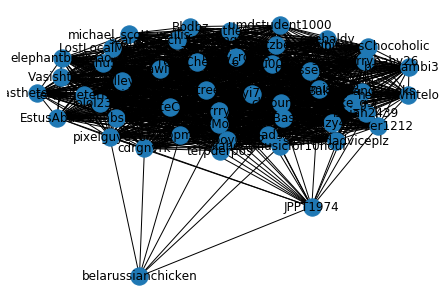

In [160]:
top_subs = (df_user_sub['subreddit'].value_counts()/df_user_sub['subreddit'].count())[:10]*100
subs = top_subs.index.tolist()
users = set(df_user_sub.name.tolist())

G=nx.Graph()
df_user_sub.drop_duplicates(subset=None, keep='first', inplace=True)
df_user_sub = df_user_sub.reset_index(drop=True)

gb = df_user_sub.head(1000).groupby('subreddit')    
gb = [gb.get_group(x) for x in gb.groups]

l = list()
names = list()

for name in gb :
#     try :
#         G['UMD'][name.iloc['subreddit']]['weight'] += 1
#     except KeyError:
#         G.add_edge('UMD', row['subreddit'], weight=1 )
        
    if (name.subreddit.reset_index(drop=True)[0] in subs) :
        for i in range(len(name) - 1) :
            if (name.iloc[i]['name'] in users) :
                for j in range(i+1, len(name)) :
                    if (name.iloc[j]['name'] in users) :
                        try :
                            G[name.iloc[i]['name']][name.iloc[j]['name']]['weight'] += 1
                        except KeyError:
                            G.add_edge(name.iloc[i]['name'], name.iloc[j]['name'], weight=1 )

nx.draw(G, with_labels=True)
plt.show()

# pos=nx.fruchterman_reingold_layout(G)   
# pos

In [130]:
G=nx.Graph()
G.add_nodes_from(['poop','jack'])
G.add_node('poop')
G.add_edge('poop', 'jack', weight=4.7 )
G['poop']['jack']['weight'] += 3.7

df_user_sub_poop = df_user_sub.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)
df_user_sub.head(50)

,name,subreddit
0,Baking-and-books,UMD
1,Baking-and-books,InfinityTrain
2,Baking-and-books,softwaregore
3,Baking-and-books,HongKong
4,Baking-and-books,gaming
5,Baking-and-books,Breadit
6,Baking-and-books,terriblefacebookmemes
7,Baking-and-books,HydroHomies
8,Baking-and-books,lolgrindr
9,Baking-and-books,Cooking


In [20]:
from nltk.corpus import movie_reviews
import random
nltk.download('movie_reviews')
documentsss = [(list(movie_reviews.words(fileid)), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]
len(documentsss)

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


2000

In [86]:
import en_core_web_sm
from wordsegment import load, segment
load()
segment('thisisatest')
segment('malefashionadvice')

import spacy

nlp = en_core_web_sm.load()
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc.ents:
    print(token.text, token.label_)


Apple ORG
U.K. GPE
$1 billion MONEY


In [3]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [4]:
df_user_sub

,name,subreddit
0,Baking-and-books,UMD
1,Baking-and-books,InfinityTrain
2,Baking-and-books,softwaregore
3,Baking-and-books,HongKong
4,Baking-and-books,gaming
5,Baking-and-books,UMD
6,Baking-and-books,UMD
7,Baking-and-books,Breadit
8,Baking-and-books,UMD
9,Baking-and-books,UMD


In [13]:
len(documents)

86988

In [26]:
df_bott = df_comment[df_comment['name'].str.endswith("bot")]

In [27]:
df_bott

,id,name,body,score,parent_id,link_id,created_utc
642,f7en2fe,bruh__bot,## bruh 😤😡😤🤡🤙,16,t1_f7en274,t3_dvsnp1,1.573661e+09
1547,f76zuc1,cs_bot,Thanks a ton!,1,t1_f7541e3,t3_dtte9y,1.573440e+09
1548,f70kmo2,cs_bot,Nope,1,t1_f6z451e,t3_dtte9y,1.573329e+09
4970,f4owp2w,phonebatterylevelbot,this phone's battery is at 4% and needs chargi...,-5,t3_dlb15j,t3_dlb15j,1.571710e+09
5090,f4ozygz,bruh__bot,## bruh 🙌🔥🔥🙌👏,2,t1_f4ozy79,t3_dl30c7,1.571712e+09
8776,f258e7v,bruh__bot,## bruh 👏😂😂😂😂,1,t1_f258dxk,t3_dbwsuz,1.569968e+09
12909,ezvkscm,bruh__bot,## bruh 💀😡😤😝🤤,27,t1_ezvksav,t3_d2kea2,1.568182e+09
17663,ex5yk9o,converter-bot,928 yards is 848.56 meters,0,t1_ex5yjqz,t3_crfq0j,1.566035e+09
20727,evb2jyl,bruh__bot,bruh 😤😤💪💪🔥🔥,11,t1_evb2jid,t3_cj4131,1.564364e+09
20909,ev8lcaq,sneakpeekbot,Here's a sneak peek of /r/gatekeeping using th...,0,t1_ev8lbt8,t3_ciheqr,1.564283e+09
